# PROBLEMA:
## O problema é que a resolução desse dataset é muito grande. E portanto o barbs() acaba plotando muitas barbelas (os arrays de latitude e longitude andam num passo d 0.25)

In [79]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
from datetime import datetime
import os
import seaborn as sns
import metpy.calc as mpcalc
import re
import calendar
from matplotlib.offsetbox import AnchoredText
import warnings
from cftime import DatetimeNoLeap
from scipy import interpolate
sns.set()

# Algumas linhas de teste

## Código começa um pouco mais abaixo

In [69]:
datau = xr.open_dataset("uwnd_79_20.nc")
u = datau.u[:,0,0,:,:]
   
datav = xr.open_dataset("vwnd_79_20.nc")
v = datav.v[:,0,0,:,:]

tempo = ['1979-01-01','2010-12-01']
time_slice = slice(tempo[0],tempo[1])
    
Umedia_mes = u.sel(time=time_slice).groupby('time.month').mean()
Vmedia_mes = v.sel(time=time_slice).groupby('time.month').mean()
    
magnitude = ((Umedia_mes)**2 + (Vmedia_mes)**2)**0.5
    
    
lons = Umedia_mes.longitude.values    #1D
lats = Vmedia_mes.latitude.values     #1D

Uvel, lonu = add_cyclic_point(Umedia_mes.sel(month=1), coord=lons)  #interpolando o grafico/ corrigindo a descontinuidade do meridiano
Vvel, lonv = add_cyclic_point(Vmedia_mes.sel(month=1), coord=lons)

lon_cut= np.arange(-70,20.5,2.5)
lat_cut= np.arange(20,-70.5,-2.5)

#Uvel_interp = np.interp(Uvel, lat_cut, lon_cut)

# Código oficial começa aqui.

In [28]:
def set_data(tempo, level):
    
    datau = xr.open_dataset("uwnd_79_20.nc")
    u = datau.u[:,0,level,:,:]
    
    datav = xr.open_dataset("vwnd_79_20.nc")
    v = datav.v[:,0,level,:,:]
    
    time_slice = slice(tempo[0],tempo[1])
    
    Umedia_mes = u.sel(time=time_slice).groupby('time.month').mean()
    Vmedia_mes = v.sel(time=time_slice).groupby('time.month').mean()
    
    magnitude = ((Umedia_mes)**2 + (Vmedia_mes)**2)**0.5
    
    
    lons = Umedia_mes.longitude.values    #1D
    lats = Vmedia_mes.latitude.values     #1D
    
    
    return lons, lats, Umedia_mes, Vmedia_mes, magnitude

In [29]:
def figura(tempo1, tempo2, level, mes):
    
    fig, ax = plt.subplots(nrows=1,ncols=2,subplot_kw=dict(projection = ccrs.PlateCarree()), figsize=(32,26))
    if level == 0:
        fig.suptitle('Comparativo\nCampo de ventos 700 hPA', fontsize=34, weight='bold', y = 0.75, x = 0.505)
    else:
        fig.suptitle('Comparativo\nCampo de ventos 850 hPA', fontsize=34, weight='bold', y = 0.75, x = 0.505)
    
    #mes = [1,2,3,4,5,6,7,8,9,10,11,12]
    
    plott(ax[0], mes, tempo1, level)
    plott2(ax[1], mes, tempo2, level)

## Esse primeiro plot mostra o barbs ocupando toda a figura:

In [34]:
def plott(ax, mes, tempo1, level):
    
    lons, lats, Umedia_mes, Vmedia_mes, magnitude = set_data(tempo2 , level)
    
    Uvel, lonu = add_cyclic_point(Umedia_mes.sel(month=mes), coord=lons)  #interpolando o grafico/ corrigindo a descontinuidade do meridiano
    Vvel, lonv = add_cyclic_point(Vmedia_mes.sel(month=mes), coord=lons)
    
    
    #lons                                    1D
    #lats                                    1D
    #Uvel = Umedia_mes.sel(month=mes)        #2D
    #Vvel = Vmedia_mes.sel(month=mes)        #2D
    
    clevs = np.arange(0,14,0.5)
    
    magnitude = ((Uvel)** 2 + (Vvel)** 2) ** 0.5
    
    cf = ax.contourf(lonu, lats, magnitude, clevs, cmap = 'jet_r')
    
    norm = mpl.colors.Normalize(vmin=0, vmax=12)
    
    
    brb = ax.barbs(lonu, lats, Uvel, Vvel, length=7, cmap = 'jet_r', norm=norm, linewidth =15)
    
   # sp = ax.streamplot(lonu, lats, Uvel, Vvel,                           # Esse Streamplot só está aqui, pois foi a solução que
    #               linewidth = 1,                                        # substituiu as barbelas...
     #              arrowsize = 1,
      #           density = 5,
       #             #color = magnitude,
        #           #cmap='RdBu',
         #          norm=norm,
          #         transform=ccrs.PlateCarree())

    
    cbar = plt.colorbar(brb, orientation='horizontal', pad=0.05 , ax=ax, shrink = 1.0, aspect=40)
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label("m/s", fontsize = 17, y = 0.3)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='black', alpha=0.3, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.ylines = True
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator(np.arange(-70, 50, 20)) #-70,50,20
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    
    ax.coastlines('50m')
    ax.set_extent([-70, 20, -50, 10])
    ax.set_title(calendar.month_abbr[mes], fontdict={'fontsize': 30}, loc = 'right')
    ax.set_title('2018 até 2019', fontdict={'fontsize': 30}, loc = 'left')

## Aqui seria o gráfico da segunda imagem para ser comparada, e é nela que estou fazendo os testes do 'barbs' :

In [31]:
def plott2(ax, mes, tempo2, level):
    
    lons, lats, Umedia_mes, Vmedia_mes, magnitude = set_data(tempo2 , level)
    
    Uvel, lonu = add_cyclic_point(Umedia_mes.sel(month=mes), coord=lons)  #interpolando o grafico/ corrigindo a descontinuidade do meridiano
    Vvel, lonv = add_cyclic_point(Vmedia_mes.sel(month=mes), coord=lons)
    
    
    #lons                                    1D
    #lats                                    1D
    #Uvel = Umedia_mes.sel(month=mes)        #2D
    #Vvel = Vmedia_mes.sel(month=mes)        #2D
    
    clevs = np.arange(0,14,0.5)
    
    magnitude = ((Uvel)** 2 + (Vvel)** 2) ** 0.5
    
    cf = ax.contourf(lonu, lats, magnitude, clevs, cmap = 'jet_r')
    
    norm = mpl.colors.Normalize(vmin=0, vmax=12)
    
    
    
    #brb = ax.barbs(lon_cut, lat_cut, Umedia_mes_interp, Vmedia_mes_interp, scale=300, minshaft=3, transform=ccrs.PlateCarree())
    
    lon_cut= np.arange(-70,20.5,2.5)
    lat_cut= np.arange(20,-70.5,-2.5)
    
    Uvel_interp = Uvel.interp(latitude = lat_cut, longitude = lon_cut)
    
    brb = ax.barbs(lon_cut, lat_cut, Uvel, Vvel, length=7, cmap = 'jet_r', norm=norm, linewidth =15)
    
    
    cbar = plt.colorbar(brb, orientation='horizontal', pad=0.05 , ax=ax, shrink = 1.0, aspect=40)
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label("m/s", fontsize = 17, y = 0.3)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='black', alpha=0.3, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.ylines = True
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator(np.arange(-70, 50, 20)) #-70,50,20
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    
    ax.coastlines('50m')
    ax.set_extent([-70, 20, -50, 10])
    ax.set_title(calendar.month_abbr[mes], fontdict={'fontsize': 30}, loc = 'right')
    ax.set_title('2018 até 2019', fontdict={'fontsize': 30}, loc = 'left')


In [32]:
tempo1 = ['1979-01-01','2010-12-01']
tempo2 = ['2018-01-01','2019-12-01']

# 0 = '700' hPA
# 1 = '850' hPA
#figura(tempo1, tempo2, level, mes escolhido)
    #level: 0 = '700' hPA   ou   1 = '850' hPA  
    #mes escolhido = [1 até 12]

AttributeError: 'MaskedArray' object has no attribute 'interp'

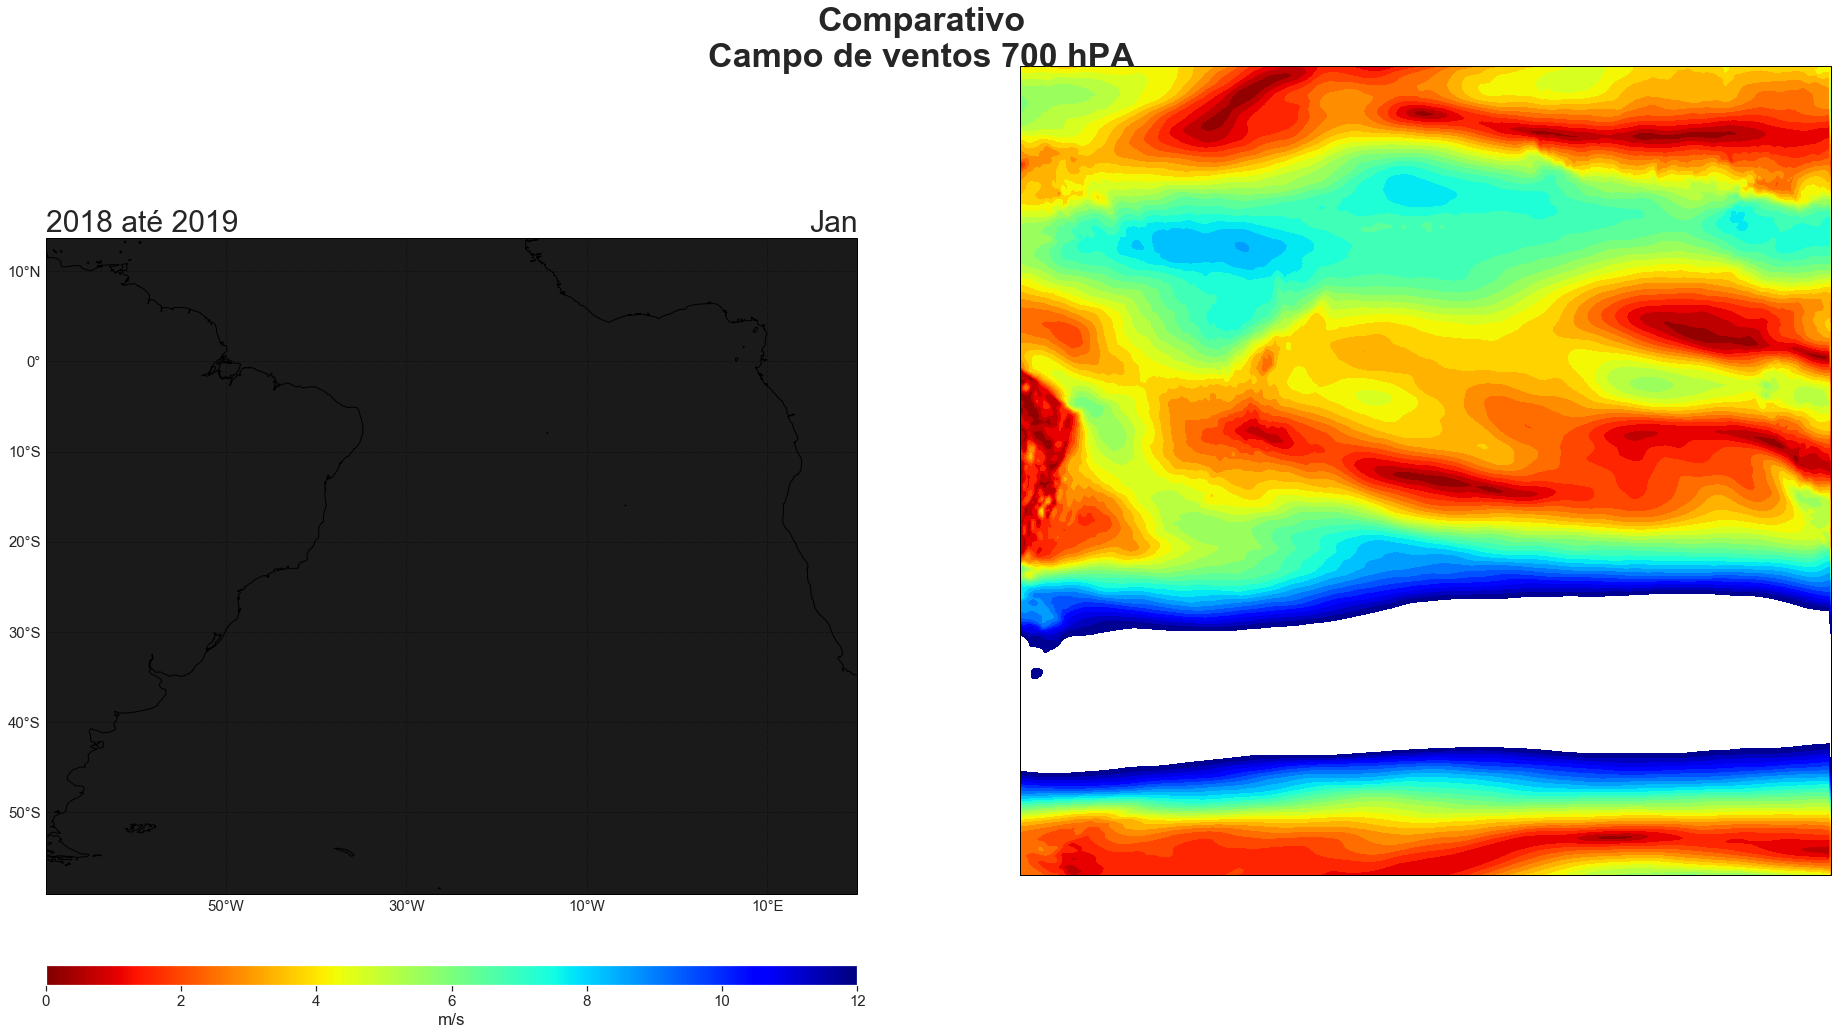

In [33]:
figura(tempo1, tempo2, 0, 1)